In [11]:
from twitch import TwitchClient
import tweepy
import pandas as pd
import requests
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret,twitch_client_id)

from datetime import timedelta

client = TwitchClient(client_id=twitch_client_id)
#channel = client.channels.get_by_id(44322889)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())
currtime = datetime.datetime.now().strftime('%m/%d/%y')



ModuleNotFoundError: No module named 'simplejson'

In [2]:
games = len(client.games.get_top())
top_games = []
popularity = []
viewers = []
channels = []
for i in range(games):
    top_games.append(client.games.get_top()[i]['game']['name'])
    popularity.append(client.games.get_top()[i]['game']['popularity'])
    viewers.append(client.games.get_top()[i]['viewers'])
    channels.append(client.games.get_top()[i]['channels'])



df = pd.DataFrame({
    'Game' : top_games,
    'Popularity' : popularity,
    'Views': viewers,
    'Channels': channels
}
)

datestamp = datetime.datetime.now().strftime('%m_%d_%y')
df.to_csv(f'game_data_{datestamp}.csv')


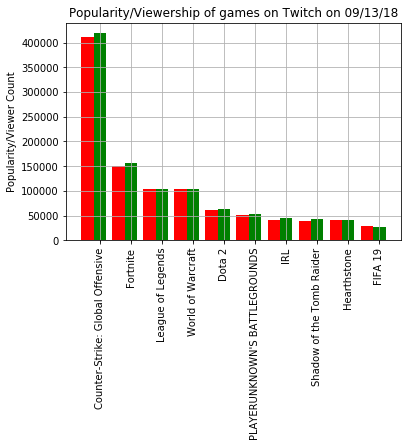

In [3]:
x = np.arange(len(df['Game']))
fig,ax = plt.subplots()

ax.bar(x -0.4 ,df['Popularity'],color='red',align='center',width = 0.4)
ax.bar(x,df['Views'],color='green',align='center',width = 0.4)
ax.set_xticks(x,df['Game'].tolist())
ax.set_ylabel('Popularity/Viewer Count')
ax.grid()
ax.set_title(f'Popularity/Viewership of games on Twitch on {currtime}')
plt.xticks(x,df['Game'].tolist(), rotation=90)
plt.savefig('bar_GamePopularityVsView.png')
plt.show()

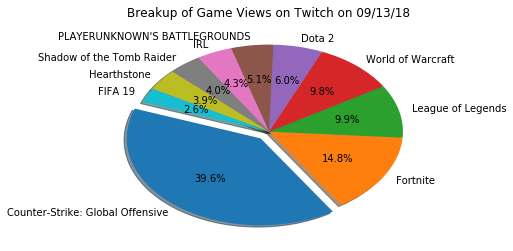

In [4]:
explode=[0.1,0,0,0,0,0,0,0,0,0]
plt.pie(df['Views'],labels=df['Game'].tolist(),shadow=True,startangle=160,explode=explode, autopct='%.1f%%')
plt.title(f'Breakup of Game Views on Twitch on {currtime}')
plt.savefig('pie_GameViewsOnTwitch.png')
plt.show()

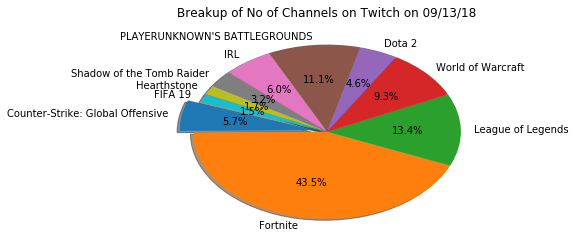

In [5]:
explode=[0.1,0,0,0,0,0,0,0,0,0]
plt.pie(df['Channels'],labels=df['Game'].tolist(),shadow=True,startangle=160,explode=explode, autopct='%.1f%%')
plt.title(f'Breakup of No of Channels on Twitch on {currtime}')
plt.savefig('pie_GameChannelsOnTwitch.png')
plt.show()

In [6]:
#Run twitter analysis

games = df['Game'].tolist()
counter = 0
gamelist=[]
texts=[]
location=[]
sentiments=[]
tweets_apart=[]
created=[]
createdFormatted=[]

for game in games:
    oldest_tweet = None
    for x in range(5):
        public_tweets = api.search(game, 
                               count=100, 
                               result_type="recent", 
                               max_id=oldest_tweet)
        for tweet in public_tweets["statuses"]:
            gamelist.append(game)
            texts.append(tweet['text'])
            #location.append(tweet['location'])
            analysis = analyzer.polarity_scores(tweet['text'])
            sentiments.append(analysis['compound'])
            created.append(tweet['created_at']) 
            createdFormatted.append(datetime.datetime.strptime(tweet['created_at'], "%a %b %d %H:%M:%S %z %Y"))
            oldest_tweet = tweet["id"] - 1
    






In [7]:

df_tweets = pd.DataFrame({
    'Games': gamelist,
    'Tweet Text': texts,
    'Sentiments': sentiments,
    'Created At': created,
    'Created At Formatted':createdFormatted
}
)


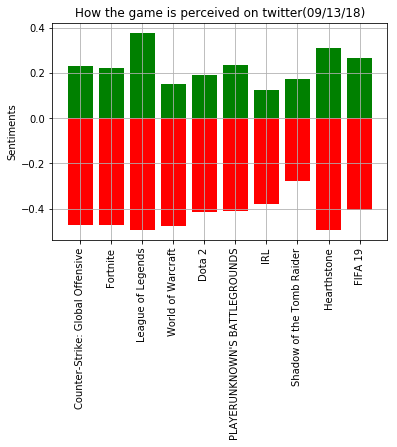

In [8]:

df_positive = df_tweets.loc[df_tweets['Sentiments'] >=0 ].groupby('Games')
df_negative = df_tweets.loc[df_tweets['Sentiments'] <0 ].groupby('Games')

x = np.arange(len(df['Game']))
fig,ax = plt.subplots()

ax.bar(x ,df_positive['Sentiments'].mean(),color='green',align='center',width = 0.8)
ax.bar(x,df_negative['Sentiments'].mean(),color='red',align='center',width = 0.8)
ax.set_xticks(x,df['Game'].tolist())
ax.set_ylabel('Sentiments')
ax.grid()
ax.set_title(f'How the game is perceived on twitter({currtime})')
plt.xticks(x,df['Game'].tolist(), rotation=90)
plt.savefig('GameTweetAnalysis.png')
plt.show()

In [14]:
base_url = 'https://contextualwebsearch.com/api/Search/WebSearchAPIWithPagination?q='
search_counts = []
for g in games:
    try:
        
        resp = requests.get(f'{base_url}{g}').json()
        search_counts.append(resp['totalCount'])
        
    except :
        print(f'No results found for {g}')
        
df_searches = pd.DataFrame({
    'Games': games,
    'Search Counts': search_counts
}
)   



No results found for Counter-Strike: Global Offensive
No results found for Fortnite
No results found for League of Legends
No results found for World of Warcraft
No results found for Dota 2
No results found for PLAYERUNKNOWN'S BATTLEGROUNDS
No results found for IRL
No results found for Shadow of the Tomb Raider
No results found for Hearthstone
No results found for FIFA 19


ValueError: arrays must all be same length

In [ ]:
x = np.arange(len(df_searches['Games']))
fig,ax = plt.subplots()

ax.bar(x,df_searches['Search Counts'],color='darkblue',align='center',width = 0.5)
ax.set_xticks(x,df_searches['Games'].tolist())
ax.set_ylabel('Search Count')
ax.grid()
ax.set_title(f'Game Search Footprint on ContextualWebSearch on {currtime}')
plt.xticks(x,df_searches['Games'].tolist(), rotation=90)
#plt.savefig('bar_GameSearch.png')
plt.show()

In [16]:
df_hist = pd.read_csv('game_hist.csv')


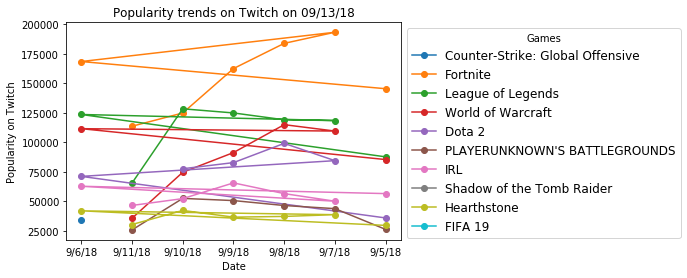

In [17]:
for g in games:

    x_axis = df_hist.loc[df_hist['Game'] == g]['Date']
    y_axis = df_hist.loc[df_hist['Game'] == g]['Popularity']
    plt.xlabel('Date')
    plt.ylabel('Popularity on Twitch')
    plt.title(f'Popularity trends on Twitch on {currtime}')
    #plt.xlim(min(x_axis),max(x_axis))
    plt.plot(x_axis,y_axis, marker='o',label=g)
    plt.legend(bbox_to_anchor=(1, 1), loc=2,fontsize="large", title="Games")

plt.savefig('trends_lastweek_1.png')

plt.show()    

In [18]:


date_list = df_tweets['Created At Formatted'].tolist()
delta = datetime.datetime.today().date() - timedelta(days=1)
p_games=[]
p_createdatf=[]
for y in range(len(date_list)-1):
    dt = df_tweets.iloc[y,4]
    if dt.date() > delta:
        p_games.append(df_tweets.iloc[y,0])
        p_createdatf.append(df_tweets.iloc[y,4])
    

df_previous = pd.DataFrame({
    'Games': p_games,
    'Created At Formatted' : p_createdatf
}
)
tweets_apart = []
tweet_creation=[]
game_list = []
for g in games:
    createdat= df_previous.loc[df_previous['Games'] == g]['Created At Formatted']
    createdat = createdat.tolist()
    for x in range(len(createdat)-1):
        game_list.append(g)
        tweets_apart.append((createdat[x] - createdat[x+1]).seconds)
        tweet_creation.append(createdat[x])


df_velocity = pd.DataFrame({
    'Games': game_list,
    'Tweets Apart':tweets_apart,
    'Tweet Created At': tweet_creation
}
)



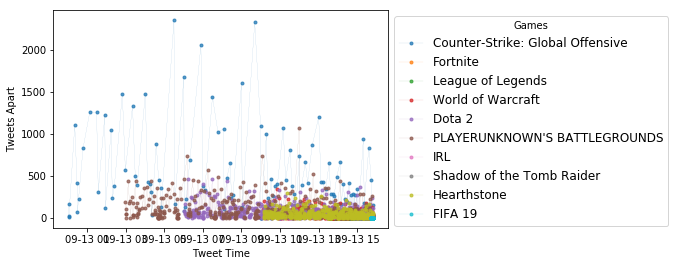

In [19]:
for g in games:
    x_axis = df_velocity.loc[df_velocity['Games'] == g]['Tweet Created At']
    y_axis = df_velocity.loc[df_velocity['Games'] == g]['Tweets Apart']
    plt.plot(x_axis,y_axis,marker='.',linewidth='0.1',label=g, alpha=0.75)

plt.ylabel('Tweets Apart')  
plt.xlabel('Tweet Time')   
plt.legend(bbox_to_anchor=(1, 1), loc=2,fontsize="large", title="Games")


plt.show()